# 07 FBS Coupling with VPT
The frequency-based substructure coupling is embedded in `pyFBS`. In particular, the admittance-based dual formulation named Lagrange-Multiplier Frequency-Based Substructuring (LM-FBS) is implemented. In this tutorial, a basic coupling of two numerically-generated substructures is presented. The virtual point transformation is applied to impose collocated matching DoFs at the interface.

In [1]:
import pyFBS

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

## Data Import
Load the required predefined datasets:

In [2]:
pyFBS.download_lab_testbench()

100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 8023.54it/s]

In [3]:
pos_xlsx = r"./lab_testbench/Measurements/coupling_example.xlsx"

stl_dir_A = r"./lab_testbench/STL/A.stl"
stl_dir_B = r"./lab_testbench/STL/B.stl"
stl_dir_AB = r"./lab_testbench/STL/AB.stl"

df_acc_A = pd.read_excel(pos_xlsx, sheet_name='Sensors_A')
df_chn_A = pd.read_excel(pos_xlsx, sheet_name='Channels_A')
df_imp_A = pd.read_excel(pos_xlsx, sheet_name='Impacts_A')

df_acc_B = pd.read_excel(pos_xlsx, sheet_name='Sensors_B')
df_chn_B = pd.read_excel(pos_xlsx, sheet_name='Channels_B')
df_imp_B = pd.read_excel(pos_xlsx, sheet_name='Impacts_B')

df_acc_AB = pd.read_excel(pos_xlsx, sheet_name='Sensors_AB')
df_chn_AB = pd.read_excel(pos_xlsx, sheet_name='Channels_AB')
df_imp_AB = pd.read_excel(pos_xlsx, sheet_name='Impacts_AB')

## 3D view
Open 3D viewer in the background. With the 3D viewer the subplot capabilities of [PyVista](https://docs.pyvista.org/index.html) can be exploited.

In [4]:
view3D = pyFBS.view3D(show_origin = False, show_axes = False, shape = (1,3), title = "Overview")

Add the STL file of substructure A to the 1-1 subplot and show the corresponding accelerometers, channels and impacts.

In [5]:
view3D.plot.subplot(0,0)
view3D.plot.isometric_view()
view3D.plot.add_text("A structure", position='upper_left', font_size=10, color="k", font="times", name="A_structure")

view3D.add_stl(stl_dir_A,color = "#83afd2",name = "A");
view3D.show_acc(df_acc_A,scale = 1000)
view3D.show_imp(df_imp_A,scale = 1000)
view3D.show_chn(df_chn_A,scale = 1000)

Add the STL file of substructure B to the 1-2 subplot and show the corresponding accelerometers, channels and impacts.

In [6]:
view3D.plot.subplot(0,1)
view3D.plot.isometric_view()
view3D.plot.add_text("B structure", position='upper_left', font_size=10, color="k", font="times", name="B_structure")

view3D.add_stl(stl_dir_B,color = "#83afd2",name = "B");
view3D.show_acc(df_acc_B,scale = 1000,overwrite = False)
view3D.show_imp(df_imp_B,scale = 1000,overwrite = False)
view3D.show_chn(df_chn_B,scale = 1000,overwrite = False)

Add STL file of the assembly AB to the 1-2 subplot and show the corresponding reference accelerometer, channels and impacts.

In [7]:
view3D.plot.subplot(0,2)
view3D.plot.isometric_view()
view3D.plot.add_text("AB structure", position='upper_left', font_size=10, color="k", font="times", name="AB_structure");

view3D.add_stl(stl_dir_AB,color = "#83afd2",name = "AB");
view3D.show_acc(df_acc_AB,scale = 1000,overwrite = False)
view3D.show_imp(df_imp_AB,scale = 1000,overwrite = False)
view3D.show_chn(df_chn_AB,scale = 1000,overwrite = False)

Each separate subplot view can also be linked or unlinked:

In [8]:
view3D.plot.link_views()
#view3D.plot.unlink_views()

## Numerical model
Load the corresponding .full and .rst file from the example datasets. For more information on .full and .rst files refer to the *03_FRF_synthetization.ipynb* example.

In [9]:
full_file_AB = r"./lab_testbench/FEM/AB.full"
ress_file_AB = r"./lab_testbench/FEM/AB.rst"

full_file_B = r"./lab_testbench/FEM/B.full"
ress_file_B = r"./lab_testbench/FEM/B.rst"

full_file_A = r"./lab_testbench/FEM/A.full"
ress_file_A = r"./lab_testbench/FEM/A.rst"

Create an MK model for each component:

In [ ]:
MK_A = pyFBS.MK_model(ress_file_A,full_file_A,no_modes = 100,allow_pickle= True,recalculate = False, scale=1000)
MK_B = pyFBS.MK_model(ress_file_B,full_file_B,no_modes = 100,allow_pickle= True,recalculate = False, scale=1000)
MK_AB = pyFBS.MK_model(ress_file_AB,full_file_AB,no_modes = 100,allow_pickle= True,recalculate = False, scale=1000)

[100]
[160]
[3]
[100]
[160]
[3]
[100]
[160]
[3]


Update locations of channels and impacts to snap to the nearest FE node.

<div class="alert alert-block alert-warning">
    <i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
    <b>Warning!</b> When performing numerical cases always make sure channels and impacts are aligned with FE nodes!
</div>

In [11]:
df_chn_A_up = MK_A.update_locations_df(df_chn_A,scale = 1000)
df_imp_A_up = MK_A.update_locations_df(df_imp_A,scale = 1000)

df_chn_B_up = MK_B.update_locations_df(df_chn_B,scale = 1000)
df_imp_B_up = MK_B.update_locations_df(df_imp_B,scale = 1000)

df_chn_AB_up = MK_AB.update_locations_df(df_chn_AB,scale = 1000)
df_imp_AB_up = MK_AB.update_locations_df(df_imp_AB,scale = 1000)

Perform the FRF sythetization for each component based on the updated locations.

In [12]:
MK_A.FRF_synth(df_chn_A_up,df_imp_A_up,f_start = 0,modal_damping = 0.003)
MK_B.FRF_synth(df_chn_B_up,df_imp_B_up,f_start = 0,modal_damping = 0.003)
MK_AB.FRF_synth(df_chn_AB_up,df_imp_AB_up,f_start = 0,modal_damping = 0.003)

## Virtual point transformation
It would be impractical to measure interface admittance for both substructures in multiple DoFs at the interface and furthermore ensure, that these DoFs are perfectly collocated. Therefore we adopt VPT in order to obtain a collocated full-DoF interface admittance matrix for each substructure.


The VPT can be performed directly on the generated data. See the *04_VPT.ipynb* example for more options and details.

In [13]:
df_vp = pd.read_excel(pos_xlsx, sheet_name='VP_Channels')
df_vpref = pd.read_excel(pos_xlsx, sheet_name='VP_RefChannels')

vpt_A = pyFBS.VPT(df_chn_A_up,df_imp_A_up,df_vp,df_vpref)
vpt_B = pyFBS.VPT(df_chn_B_up,df_imp_B_up,df_vp,df_vpref)

Apply the defined VP transformation on the FRFs:

In [14]:
vpt_A.apply_VPT(MK_A.freq,MK_A.FRF)
vpt_B.apply_VPT(MK_B.freq,MK_B.FRF)

Extract the required FRFs and the frequency vector:

In [15]:
freq = MK_A.freq
Y_A = vpt_A.vptData
Y_B = vpt_B.vptData

## LM-FBS Coupling

First, construct an admittance matrix for the uncoupled system, containing substructure admittances:

$$\mathbf{Y}^\text{A|B} = \begin{bmatrix} 
\mathbf{Y}^\text{A} & \mathbf{0} \\
\mathbf{0} & \mathbf{Y}^\text{B}
\end{bmatrix}.$$

In [16]:
Y_AnB = np.zeros((Y_A.shape[0],Y_A.shape[1]+Y_B.shape[1],Y_A.shape[2]+Y_B.shape[2]), dtype=complex)

Y_AnB[:,:Y_A.shape[1],:Y_A.shape[2]] = Y_A
Y_AnB[:,Y_A.shape[1]:,Y_A.shape[2]:] = Y_B

Next the compatibility and the equilibrium conditions has to be defined through the signed Boolean matrices ``Bu`` and ``Bf``. 

$$\mathbf{B}_\text{u}\,\boldsymbol{u} = \mathbf{0}$$
$$\boldsymbol{g} = - \mathbf{B}_\text{f}^\text{T} \boldsymbol{\lambda}$$

Make sure that the correct DoFs are selected for the coupling. In the following example the 6 virtual/generalized DoFs at the interface are matched, so the size of the Boolean matrix should be 6 $\times$ 30 (30 is the sum of all DoFs from both substructures A and B).

In [17]:
k = 6 # number of collocated DoFs at the interface

Bu = np.zeros((k,Y_A.shape[1]+Y_B.shape[1]))
Bu[:k,6:6+k] = 1*np.eye(k)
Bu[:k,12:12+k] = -1*np.eye(k)

Bf = np.zeros((k,Y_A.shape[2]+Y_B.shape[2]))
Bf[:k,6:6+k] = 1*np.eye(k)
Bf[:k,12:12+k] = -1*np.eye(k)

We inspect visually if the correct DoFs from both substructures are matched:

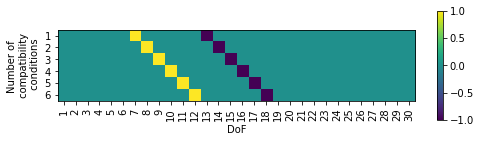

In [18]:
plt.figure(figsize=(8,4))
plt.imshow(Bu)
plt.colorbar(shrink=0.5)
plt.xlabel('DoF')
plt.ylabel('Number of \n compatibility \n conditions')
plt.xticks(np.arange(0,30,1), np.arange(1,31,1), rotation='vertical')
plt.yticks(np.arange(0,6,1), np.arange(1,7,1));

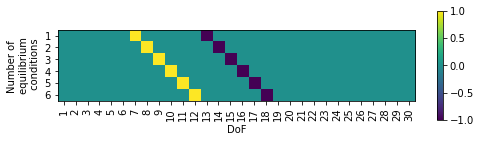

In [19]:
plt.figure(figsize=(8,4))
plt.imshow(Bf)
plt.colorbar(shrink=0.5)
plt.xlabel('DoF')
plt.ylabel('Number of \n equilibrium \n conditions')
plt.xticks(np.arange(0,30,1), np.arange(1,31,1), rotation='vertical')
plt.yticks(np.arange(0,6,1), np.arange(1,7,1));

For the LM FBS method, having defined $\mathbf{Y^{\text{A|B}}}$, $\mathbf{B}_\text{u}$ and $\mathbf{B}_\text{f}$ is already sufficient to perform coupling:

<div class="alert alert-block alert-info">
    <i class="fa fa-info-circle" aria-hidden="true"></i>
    <b>Tip:</b> Use <code>@</code> or <code>numpy.mathmul</code> for matrix multiplication.
</div>

In [20]:
Y_ABn = np.zeros_like(Y_AnB,dtype = complex)

Y_int = Bu@Y_AnB@Bf.T
Y_ABn = Y_AnB - Y_AnB@Bf.T@np.linalg.pinv(Y_int)@Bu@Y_AnB

## Results
First extract the FRFs at the reference DoFs:

In [21]:
arr_coup = [0,1,2,3,4,5,18,19,20,21,22,23,24,25,26,27,28,29]
Y_AB_coupled = Y_ABn[:,arr_coup,:][:,:,arr_coup]
Y_AB_ref = MK_AB.FRF

The coupled and the reference results of the assembled system AB can then be compared:

In [22]:
out = 0
inp = 6

pyFBS.plot_frequency_response(MK_A.freq, np.hstack((Y_AB_coupled[:,out:out+1,inp:inp+1],MK_AB.FRF[:,out:out+1,inp:inp+1])),
                              labels=('Coupled', 'Reference'))

alt.VConcatChart(...)

## ODS animation
The results of the coupling operation can be animated directly on the used output DoFs. The so-called Operational Deflection Shapes (ODS) help to visualize the solution by displaying the global motion according to a certain excitation DoF and frequency.

First open a 3D display:

In [23]:
view3D_an = pyFBS.view3D(show_origin = False, show_axes = False,title = "Animation")

Load the example datasets and display accelerometers, channels and impacts:

In [24]:
stl_dir = r"./lab_testbench/STL/AB.stl"
view3D_an.add_stl(stl_dir,color = "#83afd2",name = "AB")

view3D_an.show_acc(df_acc_AB,scale = 1000,overwrite = False)
view3D_an.show_imp(df_imp_AB_up,overwrite = False)
view3D_an.show_chn(df_chn_AB_up,overwrite = False)

view3D_an.label_acc(df_acc_AB,scale = 1000,name = "acc_AB")
view3D_an.label_chn(df_chn_AB_up,name = "chn_AB")
view3D_an.label_imp(df_imp_AB_up,name = "imp_AB")

Select the input (excitation) location and the frequency line for the ODS animation:

In [25]:
freq_sel = 20
s1 = 15
select_in = 6

#### Coupled results
Accelerometer animation based on the coupled results:

In [26]:
ann = pyFBS.orient_in_global(Y_AB_coupled[freq_sel,:,select_in],df_chn_AB_up,df_acc_AB)

mode_dict = pyFBS.dict_animation(ann,"object",object_list = view3D_an.global_acc,r_scale=30)
mode_dict["freq"] = freq[freq_sel]
view3D_an.add_objects_animation(mode_dict,run_animation = True,add_note= True)

#### Reference
Also the reference FRFs can be animated and compared with the final coupled results:

In [27]:
ann = pyFBS.orient_in_global(Y_AB_ref[freq_sel,:,select_in],df_chn_AB_up,df_acc_AB)

mode_dict = pyFBS.dict_animation(ann,"object",object_list = view3D_an.global_acc,r_scale=30)
mode_dict["freq"] = freq[freq_sel]
view3D_an.add_objects_animation(mode_dict,run_animation = True,add_note= True)